<a href="https://colab.research.google.com/github/AIinComputerVision/EVA4/blob/master/EVA4S6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Running the model for 40 epochs without L1 and L2**

In [0]:
#import all the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
validation_losses = []
train_acc = []
validation_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(test_loader.dataset)
    validation_losses.append(validation_loss)

    print('\nvalidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    validation_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08307869732379913 Batch_id=468 Accuracy=87.12: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0608, Accuracy: 9832/10000 (98.32%)

EPOCH: 1


Loss=0.07300116866827011 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0394, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.052951861172914505 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0318, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.03456934541463852 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.05141809582710266 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0299, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.02115134336054325 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:12<00:00, 36.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0291, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.09420087933540344 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.07415081560611725 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.026837775483727455 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.011729687452316284 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.03820825740695 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.004486545920372009 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.07686471194028854 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 36.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.012386982329189777 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.026470428332686424 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.0045597851276397705 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.008219629526138306 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.025268182158470154 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.008076250553131104 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.015972444787621498 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.014214073307812214 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 21


Loss=0.04530595615506172 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.018975287675857544 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0193, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.02373541332781315 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.005266179796308279 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.012188325636088848 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 37.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0179, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.021983778104186058 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 27


Loss=0.019083773717284203 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.0013307431945577264 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0177, Accuracy: 9937/10000 (99.37%)

EPOCH: 29


Loss=0.0642198696732521 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.06410235166549683 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.020002856850624084 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 36.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 32


Loss=0.02045024000108242 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.007803420070558786 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0170, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.033011648803949356 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0171, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.013722633011639118 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 36


Loss=0.007930323481559753 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)

EPOCH: 37


Loss=0.04264085367321968 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.02966270036995411 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0152, Accuracy: 9956/10000 (99.56%)

EPOCH: 39


Loss=0.03736288473010063 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]



validation set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)



Text(0, 0.5, 'accuracy in percentage')

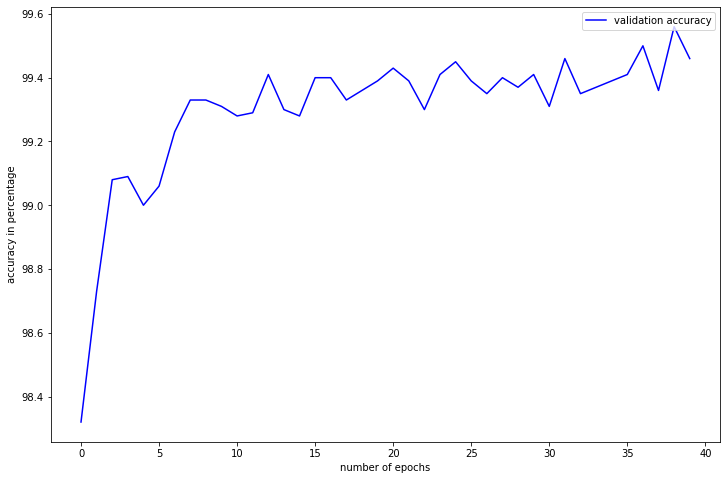

In [10]:
fig0 = plt.figure(figsize=(12,8))
plt.plot(validation_acc, color='blue')
plt.legend(['validation accuracy'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('accuracy in percentage')


Text(0, 0.5, 'negative log likelihood loss')

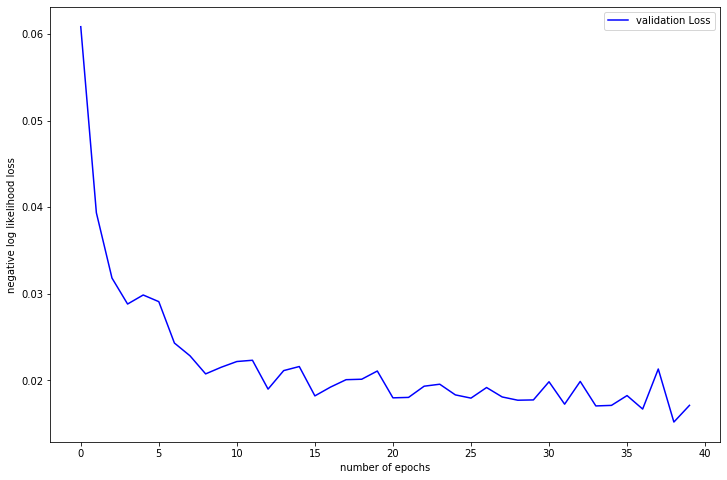

In [11]:
fig1 = plt.figure(figsize=(12,8))
plt.plot(validation_losses, color='blue')
plt.legend(['validation Loss'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('negative log likelihood loss')